In [1]:
from __future__ import print_function
import os, sys, urllib, gzip, matplotlib
sys.setrecursionlimit(10000)
%matplotlib inline
matplotlib.use('Agg') # Change matplotlib backend, in case we have no X server running..
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image as IPImage
from PIL import Image

import cPickle as pickle

from lasagne import layers
from lasagne.layers import get_output, get_output_shape, get_all_layers, get_all_params
from lasagne.layers import get_all_param_values, set_all_param_values
from lasagne import nonlinearities
from lasagne import updates 
from lasagne import objectives 
from lasagne import init 
import theano.tensor as T
import theano

sys.path.append('..')
from src import NeuralNet
from src import train as fit
from src import make_directory 
from models import load_model
from data import load_data

/home/peter/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
Using gpu device 0: GeForce GTX 980 (CNMeM is disabled, CuDNN 4007)


In [3]:
"""
name = 'Basset' # 'DeepSea'
datapath = '/home/peter/Data/'+name
options = {"class_range": range(3)}# 
train, valid, test = load_data(name, datapath, options)
shape = (None, train[0].shape[1], train[0].shape[2], train[0].shape[3])
num_labels = np.round(train[1].shape[1])

"""
name = 'MotifSimulation_binary'
datapath = '/home/peter/Data/SequenceMotif'
filepath = os.path.join(datapath, 'N=100000_S=200_M=10_G=20_data.pickle')
train, valid, test = load_data(name, filepath)
shape = (None, train[0].shape[1], train[0].shape[2], train[0].shape[3])
num_labels = np.round(train[1].shape[1])
#"""

def batch_generator(X, y, N):
    while True:
        idx = np.random.choice(len(y), N)
        yield X[idx].astype('float32'), y[idx].astype('float32')



loading data from: /home/peter/Data/SequenceMotif/N=100000_S=200_M=10_G=20_data.pickle
loading train data
loading cross-validation data
loading test data


In [8]:
# build model
input_var = T.tensor4('input')

l_in = layers.InputLayer(shape=shape, input_var=input_var, name='input')
l_conv1 = layers.Conv2DLayer(l_in, num_filters=200, filter_size=(8,1), W=init.GlorotUniform(), 
                             nonlinearity=None, b=None, pad='valid', name='conv1')
l_norm1 = layers.BatchNormLayer(l_conv1)
l_bias1 = layers.BiasLayer(l_norm1, b=init.Constant(0.05))
l_nonlin1 = layers.NonlinearityLayer(l_bias1, nonlinearity=nonlinearities.rectify)
l_pool1 = layers.MaxPool2DLayer(l_nonlin1, pool_size=(4,1))

l_conv3 = layers.Conv2DLayer(l_pool1, num_filters=200, filter_size=(8,1), W=init.GlorotUniform(), 
                             nonlinearity=None, b=None, pad='valid', name='conv1')
l_norm3 = layers.BatchNormLayer(l_conv3)
l_bias3 = layers.BiasLayer(l_norm3, b=init.Constant(0.05))
l_nonlin3 = layers.NonlinearityLayer(l_bias3, nonlinearity=nonlinearities.rectify)
l_pool3 = layers.MaxPool2DLayer(l_nonlin3, pool_size=(4,1))
l_drop3 = layers.DropoutLayer(l_pool3, p=0.3)

l_dense3 = layers.DenseLayer(l_drop3, num_units=200, W=init.GlorotUniform(), name='inter')
l_norm4 = layers.BatchNormLayer(l_dense3)
l_bias3 = layers.BiasLayer(l_norm4, init.Constant(0.05))
l_nonlin3 = layers.NonlinearityLayer(l_bias3, nonlinearity=nonlinearities.sigmoid)
l_drop4 = layers.DropoutLayer(l_nonlin3, p=0.5)

l_dense4 = layers.DenseLayer(l_drop4, num_units=20, W=init.GlorotUniform(), name='inter')
l_bias4 = layers.BiasLayer(l_dense4, init.Constant(0.05))
l_nonlin4 = layers.NonlinearityLayer(l_bias4, nonlinearity=nonlinearities.sigmoid)

l_enc = layers.NonlinearityLayer(l_nonlin4, nonlinearity=None)

l_dec5 = layers.InverseLayer(l_enc, l_dense4, name='decode')
l_bias5 = layers.BiasLayer(l_dec5, init.Constant(0.05))
l_nonlin5 = layers.NonlinearityLayer(l_bias5, nonlinearity=nonlinearities.sigmoid)

l_dec6 = layers.InverseLayer(l_nonlin5, l_dense3, name='decode')
l_norm6 = layers.BatchNormLayer(l_dec6)
l_bias6 = layers.BiasLayer(l_norm6, init.Constant(0.05))
l_nonlin6 = layers.NonlinearityLayer(l_bias6, nonlinearity=nonlinearities.sigmoid)

l_depool9 = layers.InverseLayer(l_nonlin6, l_pool3, name='depool')
l_deconv9 = layers.InverseLayer(l_depool9, l_conv3, name='deconv')
l_norm9 = layers.BatchNormLayer(l_deconv9)
l_bias9 = layers.BiasLayer(l_norm9, init.Constant(0.05))
l_nonlin9 = layers.NonlinearityLayer(l_bias9, nonlinearity=nonlinearities.rectify)
                           
l_depool8 = layers.InverseLayer(l_nonlin9, l_pool1, name='depool')
l_deconv8 = layers.InverseLayer(l_depool8, l_conv1, name='deconv')
l_norm8 = layers.BatchNormLayer(l_deconv8)
l_bias8 = layers.BiasLayer(l_norm8, init.Constant(0.05))
l_out = layers.NonlinearityLayer(l_bias8, nonlinearity=nonlinearities.rectify)


prediction = get_output(l_out)
train_loss = objectives.squared_error(prediction, input_var)
train_loss = train_loss.mean()

valid_prediction = get_output(l_out, deterministic=True)
valid_loss = objectives.squared_error(valid_prediction, input_var)
valid_loss = valid_loss.mean()

params = get_all_params(l_out, trainable=True)
update_op = updates.adam(train_loss, params)

train_function = theano.function([input_var], train_loss, updates=update_op)
valid_function = theano.function([input_var], valid_loss)


In [9]:
batch_size = 128

num_train_batches = len(train[0]) // batch_size
train_batches = batch_generator(train[0], train[1], batch_size)

n_epochs = 15
for e in range(n_epochs):
    for index in range(num_train_batches):
        X_batch, y_batch = next(train_batches)
        train_loss = train_function(X_batch)
    print("train: %f" % train_loss)


train: 0.004879
train: 0.003433
train: 0.002892
train: 0.002520
train: 0.002515
train: 0.002492
train: 0.002357
train: 0.002450
train: 0.002502


KeyboardInterrupt: 

In [10]:
full = theano.function([input_var], layers.get_output(l_out), allow_input_downcast=True)
encode = theano.function([input_var], layers.get_output(l_enc), allow_input_downcast=True)

target_var = T.dmatrix('codes')
out_expr = layers.get_output(l_out, {l_enc:target_var})
fn = theano.function([target_var, l_in.input_var], out_expr, allow_input_downcast=True)

[ 0.8265124   0.92895764  0.53943282  0.71296102  0.7897808   0.7608757
  0.56352985  0.78462529  0.44714594  0.53536981  0.96264875  0.76974922
  0.73713291  0.55756795  0.53973943  0.99704713  0.99407142  0.99282891
  0.93909556  0.93308097]
Reconstruction with Image = Original Image
Full pass through Autoencoder


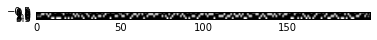

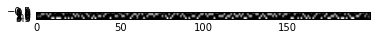

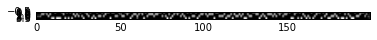

In [13]:
index = 2
orig_image = np.expand_dims(train[0][index], axis=0) 
#zero_image=np.random.rand((1,1,28,28))

# reconstruction from encoding layer
code = encode(orig_image)
print(str(np.squeeze(code)))
encode_image = fn(code, orig_image)

# full pass
#full_image = full(orig_image)

plt.figure()
plt.imshow(np.squeeze(orig_image), cmap='gray')

#print("Reconstruction with Image = Zeros")
#plt.figure()
#plt.imshow(np.squeeze(fn(code,zero_image)), cmap='gray')

print("Reconstruction with Image = Original Image")
plt.figure()
plt.imshow(np.squeeze(encode_image), cmap='gray')

print("Full pass through Autoencoder")
plt.figure()
plt.imshow(np.squeeze(full(orig_image)), cmap='gray')

#plt.figure()
#plt.imshow(np.squeeze(full_image), cmap='gray')

In [14]:
all_params = get_all_param_values(l_nonlin4)

In [17]:
input_var = T.tensor4('input')
target_var = T.dmatrix('output')

net = []
net = layers.InputLayer(shape=shape, input_var=input_var, name='input')
net = layers.Conv2DLayer(net, num_filters=200, filter_size=(8,1), W=init.GlorotUniform(), 
                             nonlinearity=None, b=None, pad='valid', name='conv1')
net = layers.BatchNormLayer(net)
net = layers.BiasLayer(net, b=init.Constant(0.05))
net = layers.NonlinearityLayer(net, nonlinearity=nonlinearities.rectify)
net = layers.MaxPool2DLayer(net, pool_size=(4,1))

net = layers.Conv2DLayer(net, num_filters=200, filter_size=(8,1), W=init.GlorotUniform(), 
                             nonlinearity=None, b=None, pad='valid', name='conv1')
net = layers.BatchNormLayer(net)
net = layers.BiasLayer(net, b=init.Constant(0.05))
net = layers.NonlinearityLayer(net, nonlinearity=nonlinearities.rectify)
net = layers.MaxPool2DLayer(net, pool_size=(4,1))
#net = layers.DropoutLayer(net, p=0.3)

net = layers.DenseLayer(net, num_units=200, W=init.GlorotUniform(), name='inter')
net = layers.BatchNormLayer(net)
net = layers.BiasLayer(net, init.Constant(0.05))
net = layers.NonlinearityLayer(net, nonlinearity=nonlinearities.sigmoid)
#net = layers.DropoutLayer(net, p=0.5)

net = layers.DenseLayer(net, num_units=20, W=init.GlorotUniform(), name='inter')
net = layers.BiasLayer(net, init.Constant(0.05))
net = layers.NonlinearityLayer(net, nonlinearity=nonlinearities.sigmoid)


In [18]:
set_all_param_values(net, all_params)

In [19]:
prediction = get_output(net)
train_loss = objectives.binary_crossentropy(prediction, target_var)
train_loss = train_loss.mean()

valid_prediction = get_output(net, deterministic=True)
valid_loss = objectives.binary_crossentropy(valid_prediction, target_var)
valid_loss = valid_loss.mean()

valid_acc = objectives.binary_accuracy(valid_prediction, target_var)
valid_acc = valid_acc.mean()

params = get_all_params(net, trainable=True)
update_op = updates.adam(train_loss, params)

train_fn = theano.function([input_var, target_var], train_loss, updates=update_op, allow_input_downcast=True)
val_fn = theano.function([input_var, target_var], [valid_loss, valid_acc], allow_input_downcast=True)


In [20]:
batch_size = 128

num_train_batches = len(train[0]) // batch_size
train_batches = batch_generator(train[0], train[1], batch_size)

num_valid_batches = len(valid[0]) // batch_size
valid_batches = batch_generator(valid[0], valid[1], batch_size)

n_epochs = 10
for e in range(n_epochs):
    ave_loss = 0
    for index in range(num_train_batches):
        X_batch, y_batch = next(train_batches)
        train_loss = train_fn(X_batch, y_batch)
        ave_loss += train_loss
    print("train: %f" % float(ave_loss/num_train_batches))

    ave_loss = 0
    ave_acc = 0
    for index in range(num_valid_batches):
        X_batch, y_batch = next(valid_batches)
        valid_loss, valid_acc = val_fn(X_batch, y_batch)
        ave_loss += valid_loss
        ave_acc += valid_acc
    print("valid: %f" % float(ave_loss/num_valid_batches))
    print("accuracy: %f" % float(ave_acc/num_valid_batches))
    
    

train: 0.640928
valid: 0.517883
accuracy: 0.954063
train: 0.449153
valid: 0.390563
accuracy: 0.954010
train: 0.343769
valid: 0.305715
accuracy: 0.957979
train: 0.277016
valid: 0.254072
accuracy: 0.958330
train: 0.234525
valid: 0.218843
accuracy: 0.959589
train: 0.205561
valid: 0.196030
accuracy: 0.960116
train: 0.187256
valid: 0.182145
accuracy: 0.959959


KeyboardInterrupt: 

In [21]:
input_var = T.tensor4('input')
target_var = T.dmatrix('output')

net = []
net = layers.InputLayer(shape=shape, input_var=input_var, name='input')
net = layers.Conv2DLayer(net, num_filters=200, filter_size=(8,1), W=init.GlorotUniform(), 
                             nonlinearity=None, b=None, pad='valid', name='conv1')
net = layers.BatchNormLayer(net)
net = layers.BiasLayer(net, b=init.Constant(0.05))
net = layers.NonlinearityLayer(net, nonlinearity=nonlinearities.rectify)
net = layers.MaxPool2DLayer(net, pool_size=(4,1))

net = layers.Conv2DLayer(net, num_filters=200, filter_size=(8,1), W=init.GlorotUniform(), 
                             nonlinearity=None, b=None, pad='valid', name='conv1')
net = layers.BatchNormLayer(net)
net = layers.BiasLayer(net, b=init.Constant(0.05))
net = layers.NonlinearityLayer(net, nonlinearity=nonlinearities.rectify)
net = layers.MaxPool2DLayer(net, pool_size=(4,1))
#net = layers.DropoutLayer(net, p=0.3)

net = layers.DenseLayer(net, num_units=200, W=init.GlorotUniform(), name='inter')
net = layers.BatchNormLayer(net)
net = layers.BiasLayer(net, init.Constant(0.05))
net = layers.NonlinearityLayer(net, nonlinearity=nonlinearities.sigmoid)
#net = layers.DropoutLayer(net, p=0.5)

net = layers.DenseLayer(net, num_units=20, W=init.GlorotUniform(), name='inter')
net = layers.BiasLayer(net, init.Constant(0.05))
net = layers.NonlinearityLayer(net, nonlinearity=nonlinearities.sigmoid)

prediction = get_output(net)
train_loss = objectives.binary_crossentropy(prediction, target_var)
train_loss = train_loss.mean()

valid_prediction = get_output(net, deterministic=True)
valid_loss = objectives.binary_crossentropy(valid_prediction, target_var)
valid_loss = valid_loss.mean()

valid_acc = objectives.binary_accuracy(valid_prediction, target_var)
valid_acc = valid_acc.mean()

params = get_all_params(net, trainable=True)
update_op = updates.adam(train_loss, params)

train_fn = theano.function([input_var, target_var], train_loss, updates=update_op, allow_input_downcast=True)
val_fn = theano.function([input_var, target_var], [valid_loss, valid_acc], allow_input_downcast=True)

batch_size = 128

num_train_batches = len(train[0]) // batch_size
train_batches = batch_generator(train[0], train[1], batch_size)

num_valid_batches = len(valid[0]) // batch_size
valid_batches = batch_generator(valid[0], valid[1], batch_size)

n_epochs = 10
for e in range(n_epochs):
    ave_loss = 0
    for index in range(num_train_batches):
        X_batch, y_batch = next(train_batches)
        train_loss = train_fn(X_batch, y_batch)
        ave_loss += train_loss
    print("train: %f" % float(ave_loss/num_train_batches))

    ave_loss = 0
    ave_acc = 0
    for index in range(num_valid_batches):
        X_batch, y_batch = next(valid_batches)
        valid_loss, valid_acc = val_fn(X_batch, y_batch)
        ave_loss += valid_loss
        ave_acc += valid_acc
    print("valid: %f" % float(ave_loss/num_valid_batches))
    print("accuracy: %f" % float(ave_acc/num_valid_batches))
    
    

train: 0.603613
valid: 0.506383
accuracy: 0.957385
train: 0.437341
valid: 0.378542
accuracy: 0.957225
train: 0.335457
valid: 0.299383
accuracy: 0.957348


KeyboardInterrupt: 